# Bayesian Hierarchical Clustering
## Prototype Build

The intent of this notebook is to implement a preliminary version of the *Bayesian Hierarchical Clustering* (BHC) algorithm.

*Sources:*

- https://cs.fit.edu/~dmitra/ArtInt/Spring2017/Projects/DM-on_ReportBayesian_Clustering_Project_Report_nlowing_rbomalaski.pdf

### Generate Example Data

Example data will consist of a mixture of three gaussian distributions with varying parameters. It will be clustered via random draws of a multinomial distribution.

In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import seaborn as sns
import itertools as it
from functools import reduce
from scipy import stats
from scipy import linalg as la
from scipy import random as rnd
from scipy.special import gamma, loggamma
import matplotlib.pyplot as plt

In [2]:
# bivariate gaussian params
mu1 = np.zeros(2)
cov1 = np.eye(2)

mu2 = np.array([5, 3])
cov2 = np.eye(2) * 2

mu3 = np.array([8, 12])
cov3 = np.array([3.4, 0, 0, 5.1]).reshape(2, 2)

# multinom params
p1 = 0.2
p2 = 0
p3 = 1 - p2 - p1

# number of total draws
draws = 60

In [3]:
# random draws
rnd.seed(1)

knum = rnd.multinomial(draws, (p1, p2, p3))

gaus1 = rnd.multivariate_normal(mu1, cov1, knum[0])
gaus2 = rnd.multivariate_normal(mu2, cov2, knum[1])
gaus3 = rnd.multivariate_normal(mu3, cov3, knum[2])

In [4]:
# join columns into dataframe
x1 = pd.Series(np.r_[gaus1[:, 0], gaus2[:, 0], gaus3[:, 0]])
x2 = pd.Series(np.r_[gaus1[:, 1], gaus2[:, 1], gaus3[:, 1]])
c = pd.Series(np.r_[np.zeros(knum[0]), np.ones(knum[1]), np.ones(knum[2]) * 2])
dat = {"x1" : x1, "x2" : x2, "c" : c}
clustData = pd.DataFrame(dat)

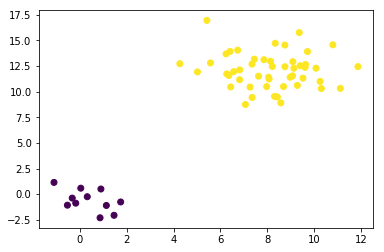

In [5]:
plt.scatter(clustData["x1"], clustData["x2"], c = clustData["c"])
plt.title("Visualizing the Clusters")
plt.show()

### Preliminary Algorithm

***BHC Steps:***


1. Input
    - Data: $D = \{\vec{x_1}, ..., \vec{x_n}\}$ 
    - Select generative model: $p(\vec{x} | \theta)$
    - Select appropriate prior: $p(\theta | \theta_0)$

2. Initialize Stage
    - Number of initial clusters: `c = len(D)`
    - $D_i = {\vec{x_i}}$ for $i = 1, ..., n$

3. Iterate Stage
    `while c > 1:`
    
    - find data pair $D_i$, $D_j$ w/ highest posterior probability for merge hypothesis: $r_k = p(H^1_k | D_k) = \frac{p(D_k | H^1_k)\pi_k}{p(D_k | T_k)}$
    - merge clusters $D_k = D_i \cup D_j$
    - delete old clusters $D_i$ and $D_j$
    - interate number of clusters `c -= 1`
    
   `end loop`

***Output:***

Bayesian mixture model where each tree node is a mixture component. Tree can be cut at points where $r_k < 0.5$.

In [6]:
### Set Clustering Prior Paramteres ###

# Gaussian Distribution - loc is mean; scale is sd
# Gamma Distribution - a is shape; scale is rate; leave loc at 0

empX = clustData.iloc[1:10,0:2].values
empXtX = empX.T @ empX

allParams = {
    "clusterConcentrationPrior" : {"alpha" : 2},
    "diffuseInvWishPrior" : {"df" : 10, "scale" : empXtX}, # inv wishart params
    "diffuseNormPrior" : {"loc" : np.mean(clustData.iloc[:,0:2], axis = 0),
                          "scale" : empXtX,
                          "meanscale" : 1}, # mvtnormal params
}


In [7]:
empX

array([[ 0.86540763, -2.3015387 ],
       [ 1.74481176, -0.7612069 ],
       [ 0.3190391 , -0.24937038],
       [ 1.46210794, -2.06014071],
       [-0.3224172 , -0.38405435],
       [ 1.13376944, -1.09989127],
       [-0.17242821, -0.87785842],
       [ 0.04221375,  0.58281521],
       [-1.10061918,  1.14472371]])

# Building Algorithm Components

### Defining the `Split` and `Leaf` Classes

The `Split` class will store all the information about a given split including the vectors that belong to that tree and subtrees.

The `Leaf` class stores fundamental information at the bottom tier.

In [8]:
class Leaf:
    """Leaf class contains information for each data point at tier 1 level"""
    
    def __init__(self, pt, clustid, priorParams):
        """initialize Leaf object
        class parameters:
        pt - an individual data point stored as a len 1 np array
        clustid - id number assigned to each leaf and used to identify
        subclusters as algorithm progresses
        priorParams - dictionary of prior parameters (e.g.
        diffuseWishPrior, diffuseNormPrior, clusterConcentrationPrior)
        class attributes:
        tier - level of the tree where the split occurs; leaves are tier 1
		alpha - cluster concentration parameter controlling
        probability of creating a new cluster k; dirichlet scaling factor
        margLik - prob of data under tree (i.e. p(Dk | Tk)); 1 for leaves
		clust - non-nested data points in cluster; leaves have clust size 1
        clustid - id number assigned to each leaf and used to identify
        subclusters as algorithm progresses
		clustsize - number of data points in cluster; leaves have clust size 1
		d - tree density parameter(?)
		pi - probability of cluster k existing
        """
        self.tier = 0
        self.alpha = priorParams["clusterConcentrationPrior"]["alpha"]
        self.priorParams = priorParams
        self.margLik = 1
        self.clust = np.array([pt])
        self.clustid = clustid
        self.clustsize = 1
        self.d = self.alpha
        self.pi = 1
        self.postMergProb = 1.0

In [9]:
class Split:
    """
    Split class stores all information about a given split
    clusti and clustj are two clusters lower in the hierarchy
    which are joined to form new cluster k
    """
    
    def __init__(self, clusti, clustj):
        """
        initialize Split object
        class parameters:
        left - a Split or Leaf object from left tree below
        right - a Split or Leaf object from right tree below
        class attributes:
        priorParams - prior parameters inherited from previous Split/ Leaf
        alpha - cluster concentration parameter controls
        prob of creating the new cluster k; inverited from previous Split/ Leaf
        tier - level of the tree where the split occurs
		alpha - cluster concentration parameter controlling
        probability of creating a new cluster k; dirichlet scaling factor
		clust - non-nested data points in cluster
        clustid - tuple of id numbers used to identify subclusters as
        algorithm progresses; see "tree consistent" in BHC paper
		clustsize - number of data points in cluster
		d - tree depth parameter(?)
		pi - prob of merging clusters i and j
        margLik - prob of data under tree (i.e. p(Dk | Tk))
        postMergProb - posterior probability for cluster k; referred to as rk
        in Heller and Ghahramani BHC paper
        """
        self.left = clusti
        self.right = clustj
        self.clustid = (self.left.clustid, self.right.clustid)
        self.priorParams = clusti.priorParams
        self.alpha = clusti.alpha
        self.tier = max(clusti.tier, clustj.tier) + 1
        self.clustsize = clusti.clustsize + clustj.clustsize
        self.clust = np.vstack([clusti.clust, clustj.clust])
        
        # calculate new d_k
        self.d = (
        	self.alpha * gamma(self.clustsize) +
        	clusti.d * clustj.d
        	)
        
        # calculate new pi_k
        self.pi = self.alpha * gamma(self.clustsize) / self.d

        # calculate marginal likelihood for this cluster (i.e. p(Dk | Tk))
        self.margLik = marginal_clust_k(self.left, self.right)

        # calculate posterior merge probability for this cluster (i.e. rk)
        self.postMergProb = posterior_join_k(self.left, self.right)

### Hypothesis Testing Helper Functions

In [10]:
def eval_H1(ci, cj):
    """
    Evaluate hypothesis 1 for merging two clusters ci and cj.
    This function assumes MVTNormal-Wishart conjugacy.
    Will need to generalize later
    ci and cj - clusters being tested for merge
    
    Inv Wish prior hyperparams:
    v - df
    S - prior precision matrix (currently defined as empirical cov mat)
    
    
    Default Normal prior hyperparams:
    m - prior mean (currently defined as sample mean)
    r - scaling factor on the prior precision of the mean
    
    hkparams - dictionary of prior parameters (e.g.
    diffuseWishPrior, diffuseNormPrior, clusterConcentrationPrior)
    """

    # abbreviated keyword arguments for brevity in calcs;
    # not the most efficient thing to do, but it's here for now...
    X = np.vstack([ci.clust, cj.clust])
    N, k = X.shape
    m = ci.priorParams["diffuseNormPrior"]["loc"]
    r = ci.priorParams["diffuseNormPrior"]["meanscale"]
    v = ci.priorParams["diffuseInvWishPrior"]["df"]
    S = ci.priorParams["diffuseInvWishPrior"]["scale"]
    
    ## version of eval_H1 from Heller appendix
    # posterior precision matrix
    Xrowsum = np.sum(X, axis = 0) # calc once for efficiency
    
    Sprime = (
        S + np.dot(X.T, X) + (r * N / (N + r)) * np.dot(m, m.T) + 
        (1 / (N + r)) * np.dot(Xrowsum, Xrowsum.T) +
        (r / (N + r)) * (np.dot(m, Xrowsum.T) + np.dot(Xrowsum, m.T))
    )

    vprime = v + N

    # components of p(D_k | H_1)
    numer = [gamma((vprime + 1 - d) / 2) for d in range(1, k + 1)]
    numer = reduce(lambda x, y: x * y, numer)
    denom = [gamma((v + 1 - d) / 2) for d in range(1, k + 1)]
    denom = reduce(lambda x, y: x * y, denom)
    
    fact = (2 ** (vprime*k/2) / 2 ** (v*k/2)) * (numer / denom)
    
    MarginalLikelihood = (
        (2 * np.pi) ** (-N * k / 2) *
        (r / (N + r)) ** (k / 2) *
        la.det(S) ** (v / 2) *
        la.det(Sprime) ** (vprime / 2) *
        fact
    )
    
    return MarginalLikelihood

In [11]:
def eval_H2(ci, cj):
    """
    probability of hypothis 2: data comes from diff distr
    ci and cj - clusters being tested for merge
    """
    return ci.margLik * cj.margLik

In [12]:
def prop_pi_k(ci, cj):
    """
    calculate the probability of merging cluster i and cluster j to create
    proposed cluster k
    ci and cj - clusters being tested for merge
    """

    # cluster size from proposed cluster k
    propClustSize = ci.clustsize + cj.clustsize

    # d_k for proposed cluster k
    propd = (
            ci.alpha *
            gamma(propClustSize) +
            ci.d * cj.d
            )

    # probability of creating proposed cluster k
    pik = ci.alpha * gamma(propClustSize) / propd

    return pik

In [13]:
def marginal_clust_k(ci, cj):
    """
    calculate the marginal likelihood for cluster k
    This is the 'evidence' in Bayes Rule; called P(D_k | T_k) in paper
    ci and cj - clusters being tested for merge
    """
    
    # calculate probability of creating proposed cluster k
    pik = prop_pi_k(ci, cj)

    # calculate probability of merge hypothesis
    pH1 = eval_H1(ci, cj)

    # calculate probability of independent hypothesis
    pH2 = eval_H2(ci, cj)

    # calculate marginal likelihood of cluster k
    marginalLikelihood = pik * pH1 + (1 - pik) * pH2

    return marginalLikelihood

In [14]:
def posterior_join_k(ci, cj):
    """
    calculate posterior probability of merged trees i & j
    ci and cj - clusters being tested for merge
    """

    # hypothesis 1 for cluster i and cluster j
    ijH1 = eval_H1(ci, cj)

    # marginal likelihood for cluster k; hypothesis 2 calculated within
    ijMarg = marginal_clust_k(ci, cj)

    # calculate probability of creating proposed cluster k
    pik = prop_pi_k(ci, cj)

    # posterior probability for creating cluster k from ci and cj
    rk = pik * ijH1 / ijMarg

    return rk

#### Example Use of `Leaf ` and `Split`:

In [15]:
x = empX[0, :]
y = empX[1, :]
z = empX[2, :]

In [16]:
# assign some leaves
lx = Leaf(x, 1, allParams)
ly = Leaf(y, 2, allParams)
lz = Leaf(z, 3, allParams)

In [17]:
# testing merges x and y
print("\nTest merge x and y")
xyH1 = eval_H1(lx, ly)
print(f"Hypothesis 1: {xyH1}")
xyH2 = eval_H2(lx, ly)
print(f"Hypothesis 2: {xyH2}")
xyPost = posterior_join_k(lx, ly)
print(f"Posterior probability for cluster k: {xyPost}\n")

# testing merges x and z
print("\nTest merge x and z")
xzH1 = eval_H1(lx, lz)
print(f"Hypothesis 1: {xzH1}")
xzH2 = eval_H2(lx, lz)
print(f"Hypothesis 2: {xzH2}")
xzPost = posterior_join_k(lx, lz)
print(f"Posterior probability for cluster k: {xzPost}\n")

# testing merges z and y
print("\nTest merge z and y")
zyH1 = eval_H1(lz, ly)
print(f"Hypothesis 1: {zyH1}")
zyH2 = eval_H2(lz, ly)
print(f"Hypothesis 2: {zyH2}")
zyPost = posterior_join_k(lz, ly)
print(f"Posterior probability for cluster k: {zyPost}\n")


Test merge x and y
Hypothesis 1: 3.274790290697563e+30
Hypothesis 2: 1
Posterior probability for cluster k: 1.0


Test merge x and z
Hypothesis 1: 1.093521078410172e+30
Hypothesis 2: 1
Posterior probability for cluster k: 1.0


Test merge z and y
Hypothesis 1: 1.6188053765565126e+30
Hypothesis 2: 1
Posterior probability for cluster k: 1.0



In [18]:
xzSplit = Split(lx, lz)

print("Joining leaf x and leaf z...\n")
print("xzSplit attributes:")
print(f"left: {xzSplit.left}")
print(f"right: {xzSplit.right}")
print(f"alpha: {xzSplit.alpha}")
print(f"tier: {xzSplit.tier}")
print(f"clustsize: {xzSplit.clustsize}")
print(f"clust:\n {xzSplit.clust}\n\n")
print(f"cluster dimensions: {xzSplit.clust.shape}")

print(f"Marginal likelihood for xzSplit: {xzSplit.margLik}")

Joining leaf x and leaf z...

xzSplit attributes:
left: <__main__.Leaf object at 0x1a1ce8ed68>
right: <__main__.Leaf object at 0x1a1ce8e978>
alpha: 2
tier: 1
clustsize: 2
clust:
 [[ 0.86540763 -2.3015387 ]
 [ 0.3190391  -0.24937038]]


cluster dimensions: (2, 2)
Marginal likelihood for xzSplit: 3.64507026136724e+29


In [19]:
# testing merges xz and y
print("\nTest merge xz and y")
xzyH1 = eval_H1(xzSplit, ly)
print(f"Hypothesis 1: {xzyH1}")
xzyH2 = eval_H2(xzSplit, ly)
print(f"Hypothesis 2: {xzyH2}")
xzyPost = posterior_join_k(xzSplit, ly)
print(f"Posterior probability for cluster k: {xzyPost}\n")


Test merge xz and y
Hypothesis 1: 7.59263689669721e+32
Hypothesis 2: 3.64507026136724e+29
Posterior probability for cluster k: 0.9985618324348707



In [20]:
xzy = Split(xzSplit, ly)
xzy.clustid

((1, 3), 2)

### Defining the `HierarchyTree` Class

The `HierarchyTree` class is the primary object for the BHC algorithm. It contains all of the `Leaf` and `Split` objects. The `grow_tree` function provides the mechanism by which the algorithm is performed.

In [21]:
### HierarchyTree helper functions ###

from functools import reduce

def get_max_posterior(propck):
    """
    find the unique combination of clusters i and j with highest
    posterior merge probability and return the new cluster
    propck - list of unique proposed combinations of
    clusters i and j
    """
    # find pair with maximum posterior probability of merge
    maxPost = reduce(
        lambda ci, cj: ci if ci.postMergProb > cj.postMergProb else cj,
        propck
    )
    
    return maxPost

###############################################################################


def place_cluster(ck, tree):
        """
        place new cluster k in appropriate tier. If tier does not exist
        this change-of-state method will create it
        """
        tree[ck.tier] = {ck.clustid : ck}
        
###############################################################################


def update_cluster_list(clist, newck):
    """
    update list of independent clusters as algorithm progresses. this list will
    reduce by one for each iteration as cclusters i and j merge into cluster k
    clist - current list of independent clusters
    newck - newly merged cluster k
    """
    clist.remove(newck.left) # remove cluster i
    clist.remove(newck.right) # remove cluster j
    clist.append(newck) # append new cluster k
    
    return clist


###############################################################################
######################### Prune Tree Helper Functions #########################
###############################################################################


def snip_splits(tier, cutpts):
    """
    cut all points in a tier identified as unjustified merge
    tier - integer identifying a tier in tree
    cutpts - list of points where cluster joins are to be seperated
    """
    for cut in cutpts:
        tier.update({tier[cut].left.clustid : tier[cut].left})
        tier.update({tier[cut].right.clustid : tier[cut].right})
        tier.pop(cut)
    
###############################################################################


def find_bad_merges(tier, rk):
    """
    find merges where posterior merge probability < rk
    tier - integer identifying a tier in tree
    rk - posterior merge probability cut threshold; defaults to 0.5
    """
    badMerges = [] # initialize list for unjustified merge ids
    for cid, s in tier.items():
        if s.postMergProb < rk:
            badMerges.append(cid) # append clustid to bad merge list
    
    return badMerges


In [22]:
from itertools import combinations

class HierarchyTree:
    """
    Primary Bayesian Hierarchical Clustering object; HierarchyTree contains
    all of the Leaf and Split objects. The tree is complete when all points
    have been agglomerated into a single hierarchical cluster.

    The grow_tree method provides the mechanism for the clustering algorithm.
    """
    
    def __init__(self, X, allParams):
        """
        Initialize HierarchyTree object
        class parameters:
        X - numpy array or pandas DataFrame to be clustered
        priorParams - dictionary of prior parameters (e.g.
        diffuseWishPrior, diffuseNormPrior, clusterConcentrationPrior)
        class attributes:
        clustCount - number of non-joined trees; incremented -1 each iter
        leaves - initial clusters of single points stored in dictionary
        currTier - current tier of tree being tested
        clusterList - list of unjoined/ independent clusters remaining to
        be tested for merge
        tree - tree grown by the bhc algorithm; dictionary of tiers;
        key is tier number and value is tier
        """
        self.clustCount = X.shape[0]
        self.leaves = {n : Leaf(i, n, allParams) for n, i in enumerate(X)}
        self.currTier = self.leaves
        self.tree = {0 : self.leaves} # tier 0 is Leaf tier
        self.clusterList = [Leaf(i, n, allParams) for n, i in enumerate(X)]
        self.tierList = [self.tree.keys()]
        
            
    def grow_tree(self):
        """
        Grow the tree over the maximum possible number of iterations.
        This means all points will be joined into a single cluster at
        the top level of the hierarchy. See `prune_tree` method.
        """
        while len(self.clusterList) > 1:
            # proposed clusters
            propClusts = [
                Split(c[0], c[1]) for c in combinations(self.clusterList, 2)
            ]
            clustk = get_max_posterior(propClusts) # highest posterior cluster
            if clustk.tier in self.tree.keys():
                self.tree[clustk.tier].update({clustk.clustid : clustk})
            else:
                self.tree[clustk.tier] = self.tree.get(
                    clustk.tier, {clustk.clustid : clustk}
                )
            self.clusterList = update_cluster_list(self.clusterList, clustk)

        
    def prune_tree(self, rk = 0.5):
        """
        Cut the tree at points where the posterior merge probability < rk
        starting from top tier and going to bottom
        rk - posterior merge probability cut threshold; defaults to 0.5
        """
        tiers = [t for t in self.tree.keys()]
        tiers.reverse() # ordered, descending integers for tiers
        for t in tiers:
            cutPoints = find_bad_merges(self.tree[t], rk)
            snip_splits(self.tree[t], cutPoints)

    def tier_summary(self, tiernum):
        """
        summarize a tier
        """
        print(f"Summary for tier {tiernum}:")
        print("-------------------------------")
        print(f"Number of clusters: {len(self.tree[tiernum].values())}")
        for n, c in enumerate(self.tree[tiernum].values()):
            print(f"  Cluster {n} size: {c.clustsize}")
            print(f"\t Posterior merge probability: {c.postMergProb:.2}")
        print("\n")
        
    def tree_summary(self):
        """
        summarize tree structure
        """
        for n in self.tree.keys():
            self.tier_summary(n)

In [23]:
ht = HierarchyTree(empX, allParams)

In [24]:
ht.grow_tree()

In [25]:
ht.prune_tree()

In [26]:
ht.tier_summary(2)

Summary for tier 2:
-------------------------------
Number of clusters: 3
  Cluster 0 size: 3
	 Posterior merge probability: 1.0
  Cluster 1 size: 2
	 Posterior merge probability: 1.0
  Cluster 2 size: 2
	 Posterior merge probability: 1.0




In [27]:
ht.tree_summary()

Summary for tier 0:
-------------------------------
Number of clusters: 9
  Cluster 0 size: 1
	 Posterior merge probability: 1.0
  Cluster 1 size: 1
	 Posterior merge probability: 1.0
  Cluster 2 size: 1
	 Posterior merge probability: 1.0
  Cluster 3 size: 1
	 Posterior merge probability: 1.0
  Cluster 4 size: 1
	 Posterior merge probability: 1.0
  Cluster 5 size: 1
	 Posterior merge probability: 1.0
  Cluster 6 size: 1
	 Posterior merge probability: 1.0
  Cluster 7 size: 1
	 Posterior merge probability: 1.0
  Cluster 8 size: 1
	 Posterior merge probability: 1.0


Summary for tier 1:
-------------------------------
Number of clusters: 4
  Cluster 0 size: 2
	 Posterior merge probability: 1.0
  Cluster 1 size: 2
	 Posterior merge probability: 1.0
  Cluster 2 size: 2
	 Posterior merge probability: 1.0
  Cluster 3 size: 2
	 Posterior merge probability: 1.0


Summary for tier 2:
-------------------------------
Number of clusters: 3
  Cluster 0 size: 3
	 Posterior merge probability: 1.0
  Cl

In [28]:
def tabular_format(tree):
    """
    output tree as pandas DataFrame object
    """
    